In this notebook we train a RealNVP based flow model to approximate the 16 dimensional Many Well Boltzmann Distribution.
Scroll down to the bottom for visualisation of results. 

In [27]:
import sys
sys.path.insert(0, "../")

In [28]:
import normflow as nf
import matplotlib.pyplot as plt
import torch

from fab import FABModel, HamiltoneanMonteCarlo, Trainer, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair

## Configure Training

In [29]:
dim: int = 16
layer_nodes_per_dim: int = 10
n_intermediate_distributions: int = 3
batch_size: int = 512
n_iterations: int = int(1e4)
n_plots: int = 5 # number of plots shows throughout tranining
lr: float = 1e-4
transition_operator_type: str = "hmc"  # "metropolis" or "hmc"
seed: int = 0
n_flow_layers: int = 20
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)

## Setup ManyWell target distribution

In [30]:
from fab.target_distributions import ManyWellEnergy
assert dim % 2 == 0
target = ManyWellEnergy(dim, a=-0.5, b=-6)
plotting_bounds = (-3, 3)

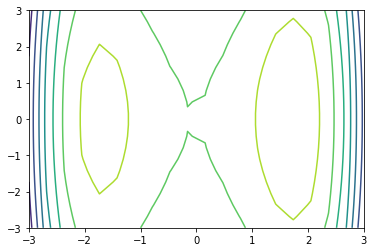

In [31]:
# plot target of 2 dimensions
plot_contours(target.log_prob_2D, bounds=plotting_bounds)

## Setup Flow
By wrapping the [normflow library](https://github.com/VincentStimper/normalizing-flows). 

In [32]:
from fab.wrappers.normflow import WrappedNormFlowModel
from fab.trainable_distributions import TrainableDistribution


def make_normflow_flow(dim: int,
                       n_flow_layers: int,
                       layer_nodes_per_dim: int):
    # Define list of flows
    flows = []
    layer_width = dim * layer_nodes_per_dim
    for i in range(n_flow_layers):
        # Neural network with two hidden layers having 32 units each
        # Last layer is initialized by zeros making training more stable
        param_map = nf.nets.MLP([int((dim / 2) + 0.5), layer_width, layer_width, dim], init_zeros=True)
        # Add flow layer
        flows.append(nf.flows.AffineCouplingBlock(param_map, scale_map="exp"))
        # Swap dimensions
        #flows.append(nf.flows.Permute(2, mode='swap'))
        # ActNorm
        #flows.append(nf.flows.ActNorm(dim))
    return flows



def make_wrapped_normflowdist(
        dim: int,
        n_flow_layers: int,
        layer_nodes_per_dim: int = 10) -> TrainableDistribution:
    """Created a wrapped Normflow distribution using the example from the normflow page."""
    base = nf.distributions.base.DiagGaussian(dim)
    flows = make_normflow_flow(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim)
    model = nf.NormalizingFlow(base, flows)
    wrapped_dist = WrappedNormFlowModel(model)
    return wrapped_dist

In [33]:
flow = make_wrapped_normflowdist(dim, n_flow_layers=n_flow_layers, layer_nodes_per_dim=layer_nodes_per_dim)

In [34]:
flow.sample((3,)).shape # check sample shape is of correct dim

torch.Size([3, 16])

## Setup transition operator

In [35]:
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltoneanMonteCarlo(
        n_ais_intermediate_distributions=n_intermediate_distributions,
        n_outer=1,
        epsilon=1.0, L=2, dim=dim,
        step_tuning_method="p_accept")
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(n_transitions=n_intermediate_distributions,
                                     n_updates=5, adjust_step_size=True)
else:
    raise NotImplementedError

## Define model, trainer and plotter

In [ ]:
# use GPU if available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    print("utilising GPU")
flow.sample((1,)).device

In [36]:
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
scheduler = None
logger = ListLogger() # save training history

In [37]:
def plot(fab_model, n_samples = 300):
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[0, 0])
    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[0, 1])
    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[1, 0])
    plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[1, 1])

    # plot flow samples
    samples_flow = fab_model.flow.sample((n_samples,))
    plot_marginal_pair(samples_flow, ax=axs[0, 0], bounds=plotting_bounds, marginal_dims=(0,1))
    plot_marginal_pair(samples_flow, ax=axs[0, 1], bounds=plotting_bounds, marginal_dims=(2,3))
    axs[0, 0].set_xlabel("dim 1")
    axs[0, 0].set_ylabel("dim 2")
    axs[0, 0].set_title("flow samples")
    axs[0, 1].set_xlabel("dim 3")
    axs[0, 1].set_ylabel("dim 4")
    axs[0, 1].set_title("flow samples")


    # plot ais samples
    samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                               logging=False)[0]
    plot_marginal_pair(samples_ais, ax=axs[1, 0], bounds=plotting_bounds, marginal_dims=(0,1))
    plot_marginal_pair(samples_ais, ax=axs[1, 1], bounds=plotting_bounds, marginal_dims=(2,3))
    axs[1, 0].set_title("ais samples")
    axs[1, 0].set_xlabel("dim 1")
    axs[1, 0].set_ylabel("dim 2")
    axs[1, 1].set_title("ais samples")
    axs[1, 1].set_xlabel("dim 3")
    axs[1, 1].set_ylabel("dim 4")
    plt.tight_layout()
    plt.show()

In [38]:
# Create trainer
trainer = Trainer(model=fab_model, optimizer=optimizer, logger=logger, plot=plot,
                  optim_schedular=scheduler)

# Run with visualisation

loss: 79.8249903253872:   0%|                                                                                                                                                                        | 0/10000 [00:00<?, ?it/s]

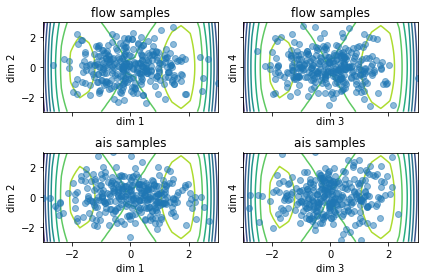

loss: 89.87271580692807:  25%|██████████████████████████████████████▉                                                                                                                     | 2499/10000 [14:46<49:53,  2.51it/s]

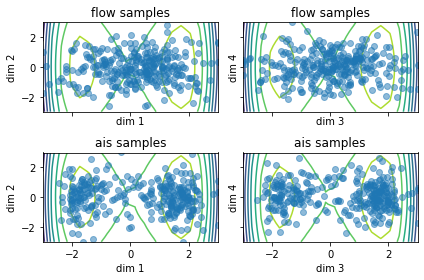

loss: 91.33660005247727:  50%|█████████████████████████████████████████████████████████████████████████████▉                                                                              | 4999/10000 [29:30<28:11,  2.96it/s]

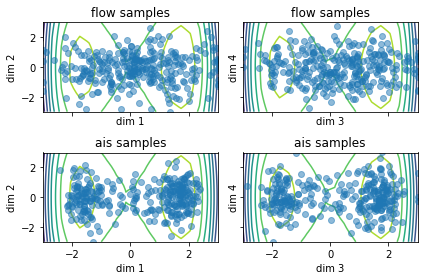

loss: 93.06704965549062:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7499/10000 [44:18<14:47,  2.82it/s]

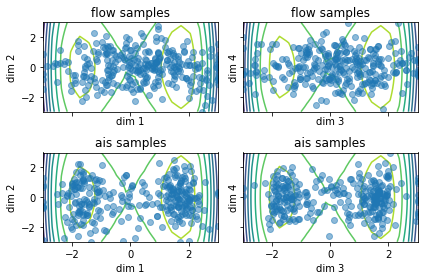

loss: 90.94739195356864: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [59:28<00:00,  2.43it/s]

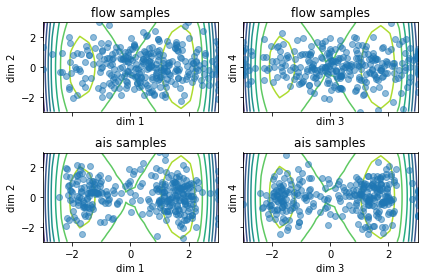

loss: 90.94739195356864: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [59:29<00:00,  2.80it/s]


In [39]:
trainer.run(n_iterations=n_iterations, batch_size=batch_size, n_plot=n_plots)

In the below plot:
ess = effective sample size
"Distance" refers to the distance moved during each intermediate transition. 

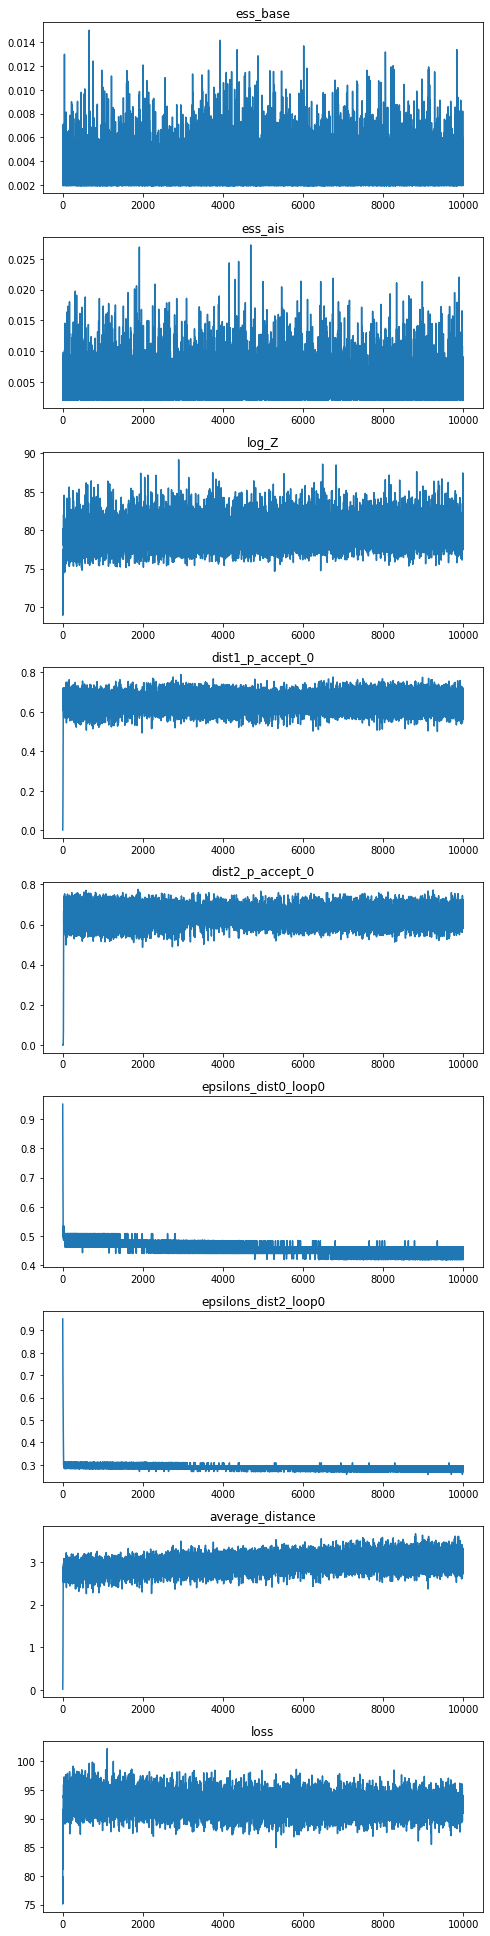

In [40]:
plot_history(logger.history)

## Visualise Trained Flow Model

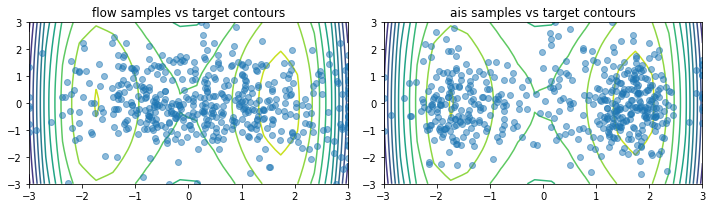

In [41]:
# plot samples on top of contours
n_samples = 500
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[0], n_contour_levels=10)
plot_contours(target.log_prob_2D, bounds=plotting_bounds, ax=axs[1], n_contour_levels=10)
# plot flow samples
samples_flow = fab_model.flow.sample((n_samples,))
plot_marginal_pair(samples_flow, ax=axs[0], bounds=plotting_bounds)
axs[0].set_title("flow samples vs target contours")
# plot ais samples
samples_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples,
                                                                           logging=False)[0]
plot_marginal_pair(samples_ais, ax=axs[1], bounds=plotting_bounds)
axs[1].set_title("ais samples vs target contours")
plt.tight_layout()